### Bayesian Inference

In [1]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline, BSpline
import numpy as np

#### Getting Data from Popular Times API

In [2]:
# import populartimes
# in order to get the data, need a Google API key
# set key = "[insert key]" and the following will run. 

# richmond_top_left = "37.785893, -122.505450"
# richmond_bottom_right = "37.774730, -122.458784"

# nb_top_left = "37.805439, -122.415333"
# nb_bottom_right = "37.796411, -122.403533"

# mission_top_left = "37.764304, -122.434895"
# missin_bottom_right = "37.753280, -122.406457"

# sunset_top_left = "37.764209, -122.510542"
# sunset_bottom_right = "37.743377, -122.475543"

# financial_top_left = "37.796259, -122.405109"
# financial_bottom_right = "37.778376, -122.387467"

# polk_top_left = "37.804409, -122.446455"
# polk_bottom_right = "37.786645, -122.414966"

# fill_top_left = "37.781955, -122.446878"
# fill_bottom_right = "37.771796, -122.411801"

# pop_nb = populartimes.get(key, ["restaurant"], (37.805439, -122.415333), (37.796411, -122.403533))
# pop_rich = populartimes.get(key, ["restaurant"], (37.785893, -122.505450), (37.774730, -122.458784))
# pop_sunset = populartimes.get(key, ["restaurant"], (37.764209, -122.510542), (37.743377, -122.475543))
# pop_fin = populartimes.get(key, ["restaurant"], (37.796259, -122.405109), (37.778376, -122.387467))
# pop_polk = populartimes.get(key, ["restaurant"], (37.804409, -122.446455), (37.786645, -122.414966))
# pop_fill = populartimes.get(key, ["restaurant"], (37.781955, -122.446878), (37.771796, -122.411801))
# pop_miss = populartimes.get(key, ["restaurant"], (37.764304, -122.434895), (37.753280, -122.406457))

#### Method for mapping file names to Neighborhood names

In [3]:
neighborhood_data = ["mission_rest_1.pickle", "nb_rest_1.pickle", "rich_rest_1.pickle", "sunset_rest_1.pickle", "fill_rest_1.pickle", "polk_rest_1.pickle", "financial_rest_1.pickle"]
def change_filename_to_neighborhood(neighb_file):
    name = ''
    if neighb_file == "mission_rest_1.pickle":
        name = 'Mission'
    if neighb_file == "nb_rest_1.pickle":
        name = "North Beach"
    if neighb_file == "rich_rest_1.pickle":
        name = 'Richmond'
    if neighb_file == "sunset_rest_1.pickle":
        name = "Sunset"
    if neighb_file == "fill_rest_1.pickle":
        name = "Fillmore"
    if neighb_file == "polk_rest_1.pickle":
        name = "Polk"
    if neighb_file == "financial_rest_1.pickle":
        name = "Financial District"
        
    return name

#### Converting data stored in pickles into one dataframe with all the data we want

In [20]:
pizza_df_2 = pd.DataFrame()
pizza_df_2['id'] = ''
pizza_df_2['Neighb'] = np.nan
pizza_df_2['Restaurant'] = ''
pizza_df_2['Hour'] = np.nan
pizza_df_2['Day'] = ''
pizza_df_2['Busyness'] = np.nan

for neighb in neighborhood_data:
    pickle_in = open(neighb,"rb")
    neighb_dict = pickle.load(pickle_in)
    for rest in neighb_dict:
        if ('pizz' in rest['name'].lower()):
            day_df = pd.DataFrame()
            for key, j in enumerate(rest['populartimes']):
                day_df['Hour'] = range(0,24)
                day_df['WeekHour'] = np.array(range(0,24))+(key*24)
                day_df['id'] = rest['id']
                day_df['Neighb'] = change_filename_to_neighborhood(neighb)
                day_df['Restaurant'] = rest['name']
                day_df['Day'] = j['name']
                day_df['Busyness'] = j['data']
                pizza_df_2 = pd.concat([pizza_df_2, day_df])

/Users/Beni/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



#### Data cleaning: removing a duplicate and distinguishing restaurants with the same name
- also adding a column for 'busyness tier'

In [22]:
pizza_df_2 = pizza_df_2[pizza_df_2.id != 'ChIJW-kUyq-AhYAR3LB-pbEOo4I']
pizza_df_2.loc[pizza_df_2['id'] == 'ChIJyzTw7X6AhYARH0MzPQHnet0', 'Restaurant'] = "Escape From New York Pizza (1)"
pizza_df_2.loc[pizza_df_2['id'] == 'ChIJhxhwkomAhYAReZ8jCsmHd5U', 'Restaurant'] = "Escape From New York Pizza (2)"
pizza_df_2.loc[pizza_df_2['id'] == 'ChIJnWzYBhh-j4AR3l6M_Ykqy8k', 'Restaurant'] = "Pizzeria Delfina (1)"
pizza_df_2.loc[pizza_df_2['id'] == 'ChIJ4zlZM8aAhYARRTqiavm0Xcs', 'Restaurant'] = "Pizzeria Delfina (2)"
pizza_df_2.loc[pizza_df_2['id'] == 'ChIJoXMvTNuBhYARcPiLzjE1biw', 'Restaurant'] = "Pizzeria Delfina (3)"
pizza_df_2['busyness_tier'] = (pizza_df_2.Busyness - 1) // 10 + 1

In [23]:
# See how often each business tier occurs relative to others, not including closed
businesses = []

non_closed = pizza_df_2[(pizza_df_2.Busyness != 0)]
for i in range (1,11):
    businesses.append(len(non_closed[non_closed.busyness_tier == i])/len(non_closed))

#### Looking at how often tiers appear as a means to create a prior

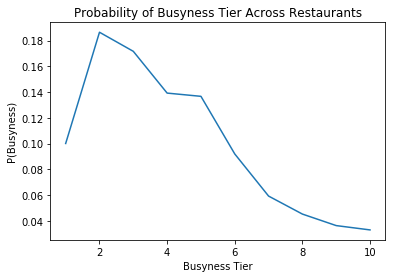

In [48]:
x = range(1,11)
plt.plot(x, businesses)
plt.xlabel('Busyness Tier')
plt.ylabel('P(Busyness)')
plt.title('Probability of Busyness Tier Across Restaurants')
plt.show()

#### Using a gamma distribution as a prior for mean busyness

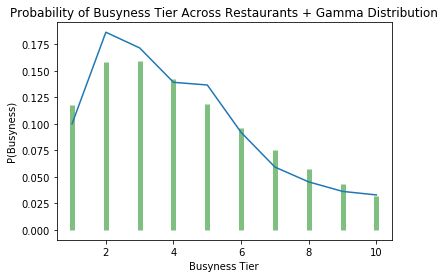

In [54]:
from scipy.stats import gamma

my_gamma = gamma.pdf(x, a=2, scale = 2.5)/sum(gamma.pdf(x, a =2, scale = 2.5))
fig, ax = plt.subplots(1, 1)
mu = 1
std = 2
x = range(1,11)
x2 = np.linspace(1,10,100)
ax.plot(x, businesses)
#ax.plot(x, norm.pdf(x, mu, std), 'bo', ms=8, label='poisson pmf')
ax.vlines(x, 0, my_gamma, colors='green', lw=5, alpha=0.5)
plt.xlabel('Busyness Tier')
plt.ylabel('P(Busyness)')
plt.title('Probability of Busyness Tier Across Restaurants + Gamma Distribution')
plt.show()

#### Methods for calculating posterior mean of busyness given neighborhood, day of week, and hour

In [26]:
def prior(x):
    # either just use the straight up percentage from the total data
    #return(businesses[x-1])

    # or use the approximation from the gamma dist
    return(gamma.pdf(x, a=2, scale = 2.5)/sum(gamma.pdf(range(1,11), a = 2, scale = 2.5)))

In [27]:
def likelihood(busyness, neighb, hour):
    busy_df = pizza_df_2[pizza_df_2.busyness_tier == busyness]
    n_busy = len(busy_df)
    return(len(busy_df[(busy_df.Neighb == neighb) & (busy_df.WeekHour == hour)])/n_busy)

In [28]:
def posterior_probabilities(neighborhood, hour):
    probabilities = []
    for busy_tier in range(1,11):
        probabilities.append(likelihood(busy_tier, neighborhood, hour) * prior(busy_tier))
    return(probabilities)

In [29]:
def max_a_posteriori(neighborhood, hour):
    post_probs = posterior_probabilities(neighborhood, hour)
    if sum(post_probs) == 0:
        return 0
    else:
        return(np.argmax(post_probs) + 1)

In [30]:
def get_neighborhood_average_busyness(neighborhood):
    restaurants_open = []
    neighb_df = pizza_df_2[(pizza_df_2.Neighb == neighborhood)]
    tier_sums = neighb_df.groupby('WeekHour').sum().busyness_tier

    for i in range(0,168):
        open_at_time = len(neighb_df[(neighb_df.WeekHour == i) & (neighb_df.Busyness > 0)])
        restaurants_open.append(open_at_time)

    return(np.nan_to_num(tier_sums/restaurants_open, 0))

In [57]:
def make_predicted_vs_actual_chart(predicted, actual, neighborhood):
    t = np.linspace(0,168,100)
    spl = make_interp_spline(range(0,168), actual, k=0)
    spl2 = make_interp_spline(range(0,168), predicted, k=0)
    smooth = spl(t)
    smooth2 = spl2(t)

    fig, ax = plt.subplots()
    ax.plot(t, smooth, 'r--')
    ax.plot(t, smooth2)

    ax.set(xlabel='Hour of Week', ylabel='avg traffic',
           title= neighborhood +" Predicted (Blue) vs Actual (Red) Average Busyness")
    ax.grid()
    plt.show()

#### Charts which show the 'actual' average busyness by hour for each neighborhood vs the maximum a posterior estimates

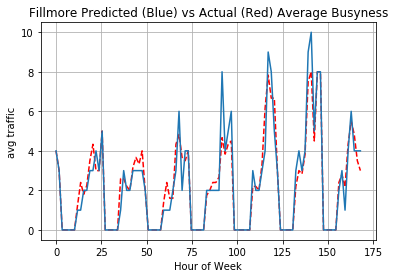

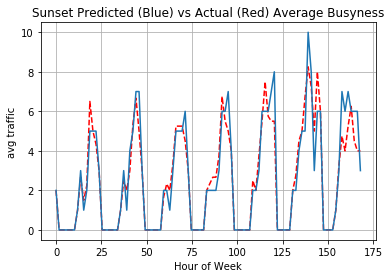

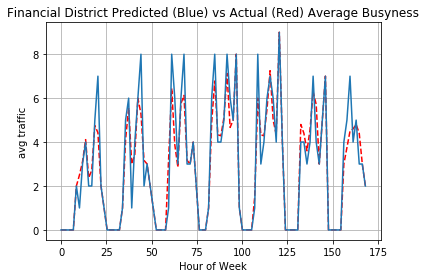

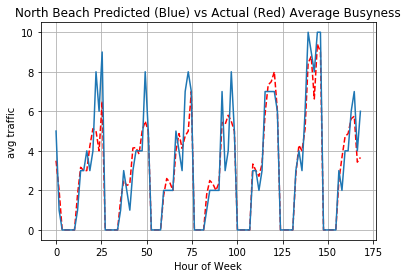

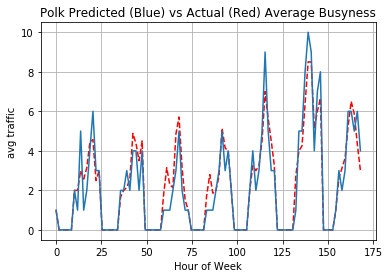

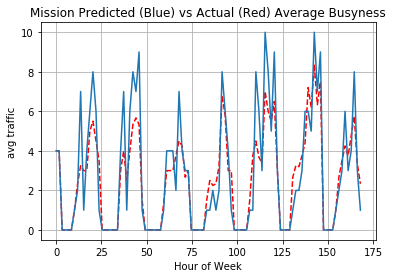

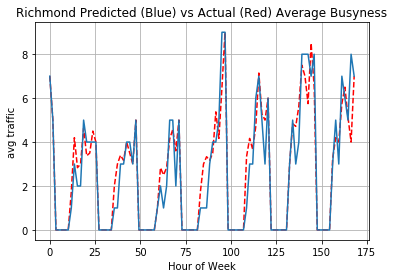

In [58]:
neighbs = list(set(pizza_df_2.Neighb))
for neighb in neighbs:
    actual_busyness = get_neighborhood_average_busyness(neighb)
    predicted_busyness = []

    for k in range(0,168):
        predicted_busyness.append(max_a_posteriori(neighb, k))
    
    make_predicted_vs_actual_chart(predicted_busyness, actual_busyness, neighb)